# Homework 5 - Independent Component Analysis

Brennan McFarland  
bfm21

In this assignment I implement gradient-based Independent Component Analysis for Blind Source Separation and apply it to the cocktail party problem.  My algorithm, implemented in the bsslib.py file, applies the BSS algorithm to a matrix of unseparated data from mixed sources and performs gradient descent on the mixing matrix until convergence, which it then uses to recover the original source data.  I first demonstrate this algorithm on a randomly generated Laplacian matrix, and then use it to separate audio files from mixed soundtracks.

### Loading the Data

I will apply the BSS algorithm to a mixture of the following speech and classical music sound files:

In [1]:
from scipy.io import wavfile

srate, dataBach = wavfile.read('data/bach.wav')
_, dataSpeech = wavfile.read('data/speech.wav')

### Normalizing the Data

This function converts the sound data to a form we can more easily manipulate by normalizing the soundtracks as numpy arrays:

In [2]:
import numpy as np

def audionorm(data):
    # ensure data is ndarray with float numbers
    data = np.asarray(data).astype('float')
    # calculate lower and upper bound
    lbound, ubound = np.min(data), np.max(data)
    if lbound == ubound:
        offset = lbound
        scalar = 1
        data = np.zeros(size=data.shape)
    else:
        offset = (lbound + ubound) / 2
        scalar = 1 / (ubound - lbound)
        data = (data - offset) * scalar
    # return normalized data
    return data

gtruthS = audionorm([dataBach, dataSpeech])

### Mixing Audio

Here we apply a simple mixing function, mixing the audio data via multiplying the source soundtracks (in a 2xn matrix, 2 for the number of soundtracks and n for the number of data points in the audio clip) by a random mixing matrix transformation.  This produces another 2xn matrix with two new soundtracks representing the mixed sounds.  We then display the data output along with our coordinate axes for the mixing matrix and save the mixed audio to their respective files.

In [3]:
def simpleMixer(S):
    nchannel = S.shape[0]
    # generate a random matrix
    A = np.random.uniform(size = (nchannel,nchannel))
    # generate mixed audio data
    X = A.dot(S)
    
    return X, A

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

def drawDataWithMixingMatrix(data, mat):
    # plot data points
    plt.scatter(data[0], data[1], s=1)
    # calculate axis length
    lenAxis = np.sqrt(np.sum(np.square(mat), axis=0))
    # calculate scale for illustration
    scale = np.min(np.max(np.abs(data), axis=1) / lenAxis.T)
    # draw axis as arrow
    plt.arrow(0, 0, scale * mat[0,0], scale * mat[1,0], shape='full', color='r')
    plt.arrow(0, 0, scale * mat[0,1], scale * mat[1,1], shape='full', color='r')

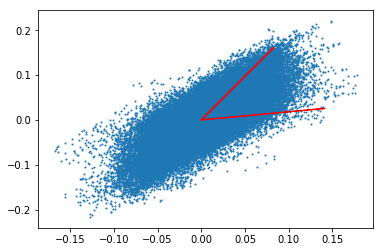

In [5]:
X, gtruthA = simpleMixer(gtruthS)
drawDataWithMixingMatrix(X, gtruthA)

In [6]:
wavfile.write('data/mixedTrackA.wav', srate, X[0])
wavfile.write('data/mixedTrackB.wav', srate, X[1])

### Optimization Functions

For this implementation of BSS we are assuming no noise, and therefore we can represent the unmixing process by the formula  
$x = As$  
where x is the mixed soundtracks, A is the mixing matrix and s is the original sources/signals.  Thus unmixing the signals/sources is as simple as matrix multiplication with the inverse of the mixing matrix:  
$s = A^{-1}x$
The algorithm functions by estimating A and updating it in the direction of our estimate's gradient.  The gradient is calculated according to the equation  
$gradA = -A(zs^{T} + I)$  
where $s^{T}$ is the transpose of our signal matrix and z is the matrix composed of $z_{i}=\frac{d}{ds}log((P(s_{i}))$.  
Since this is equivalent to $\frac{d}{ds}log(e^{|\frac{-s_{i}}{\lambda}|^{q}}) = -|\frac{s_{i}}{\lambda}|^{q-1}$,  
and q=1 since we are assuming a Laplacian distribution so $z = -sign(s)$

In [7]:
from bsslib import bss

### Verifying on Synthetic Data

First, we verify that the algorithm works by applying it to random data.  Note that as the algorithm assumes a Laplacian distribution, the test data must also follow this distribution and this is taken into account when generating the matrix.  Also, every few iterations of the gradient descent the norm and mixing matrix is printed to show its convergence.  Since the gradient of the mixing matrix is indicative of the slope of the problem space, the norm of the gradient is indicative of the error of our mixing matrix estimation.  This is useful both for a stopping criterion, as the algorithm halts once the gradient's norm falls below a certain threshold, and for indicating the progress of convergence to the ground truth mixing matrix.  Thus, in addition to being printed every few iterations, I chose to plot its decrease over time to visually indicate convergence.

gradient norm:  33485.4760590088
mixing matrix:  [[1494.72503309   -7.05158633]
 [ -19.28581994 2997.85417176]]
gradient norm:  4076.6946247128776
mixing matrix:  [[13299.74474315   280.15564425]
 [ -732.72397966 26676.60895409]]
gradient norm:  739.9705340028148
mixing matrix:  [[14719.70312361   692.33460377]
 [-1532.20678777 29519.94848529]]
gradient norm:  1023.5348743632755
mixing matrix:  [[14832.2313363   1469.36265368]
 [-2917.16593425 29734.57686374]]
gradient norm:  1871.7459719390608
mixing matrix:  [[14644.18382335  2716.67248426]
 [-5368.0318022  29362.97279961]]
gradient norm:  3184.1789532124967
mixing matrix:  [[13971.16471369  4819.11966865]
 [-9691.07780525 28029.73790351]]
gradient norm:  3266.7612703687564
mixing matrix:  [[ 12436.88275045   7473.52272688]
 [-15093.40599613  24940.03439232]]
gradient norm:  1806.36229861336
mixing matrix:  [[ 10722.76186873   9307.41371007]
 [-18870.79274569  21566.36473934]]
gradient norm:  465.1751406177683
mixing matrix:  [[ 1006

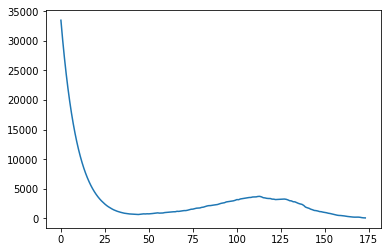

In [8]:
from bsslib import syntheticDataGenerate

# quantity of data points
nsamples = 10000
# specific mixing matrix (for illustration purpose)
verifyA = np.asarray([[-1, 1],[2, 2]])
# generate synthetic data
synthData = syntheticDataGenerate(verifyA, nsamples)
# do optimization with bss function
estimateA, recoverData = bss(synthData)

And note how well our estimated mixing matrix converges to the ground truth value as compared below:

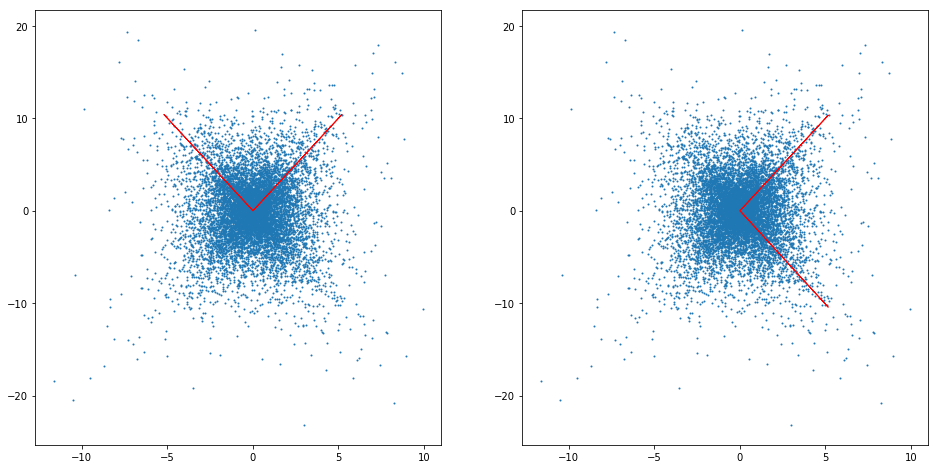

In [9]:
def compareMixingMatrix(data, matA, matB):
    plt.figure(figsize=(16, 8))
    # plot first mixing matrix
    plt.subplot(1,2,1)
    drawDataWithMixingMatrix(data, matA)
    # plot first mixing matrix
    plt.subplot(1,2,2)
    drawDataWithMixingMatrix(data, matB)
    
compareMixingMatrix(synthData, verifyA, estimateA)

### Applying to Mixed Sound Tracks

Now that we know the algorithm is accurate, we can apply it to the mixed sound tracks we generated earlier and write the separated tracks to their respective audio files:

gradient norm:  7781.947481233633
mixing matrix:  [[358.1548549  402.05667333]
 [284.74812641 486.07361459]]
gradient norm:  731.8424490997927
mixing matrix:  [[2005.3891946  2288.35546743]
 [ 312.11339454 4295.56693667]]
gradient norm:  92.31761400946566
mixing matrix:  [[2275.20097733 2489.17132452]
 [ 437.83848409 4753.28069187]]


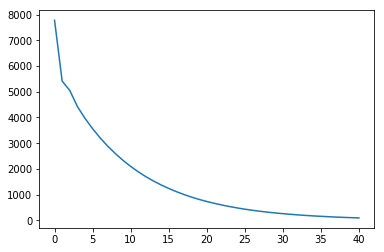

In [10]:
A, S = bss(X)

In [11]:
# normalized sound tracks
S = audionorm(S)
# write recovered sound track into WAV files
wavfile.write('data/separatedTrackA.wav', 22050, S[0])
wavfile.write('data/separatedTrackB.wav', 22050, S[1])

### Evaluating the Results

We can then compare our estimated mixing matrix to the ground truth:

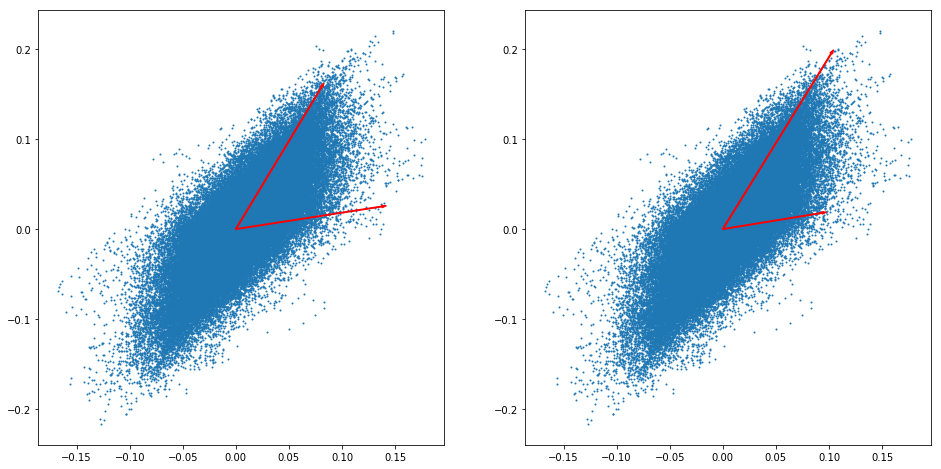

In [12]:
compareMixingMatrix(X, gtruthA, A)

In [13]:
print('\nMixing Matrix (Our Estimation)\n\n', A)
print('\nMixing Matrix (Groud Truth)\n\n', gtruthA)


Mixing Matrix (Our Estimation)

 [[2275.20097733 2489.17132452]
 [ 437.83848409 4753.28069187]]

Mixing Matrix (Groud Truth)

 [[0.21815098 0.37051441]
 [0.42621966 0.06762279]]


Notice how our mixing matrix estimation is drastically different from the ground truth.  Notice, though, that the basis vectors are simply flipped, meaning that although they numerically appear very different, the coordinate axes representing our data transformation are still equivalent and so the mixing matrix will yield the same result as with the ground truth.

### Further Exploration: Limited Sampling

Now let us suppose that iteratively calculating the gradient for the mixing matrix is computationally intractable.  We can try to remedy this by taking limited samples of our mixed soundtrack data and optimizing the mixing matrix based on those.  Since we are not making any assumptions about our signals, the only way we can avoid taking unbiased samples is to perform random sampling:

gradient norm:  160.10278206544254
mixing matrix:  [[ 8.38017632  8.37091382]
 [ 5.93982347 10.82386404]]


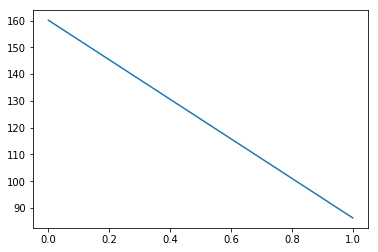

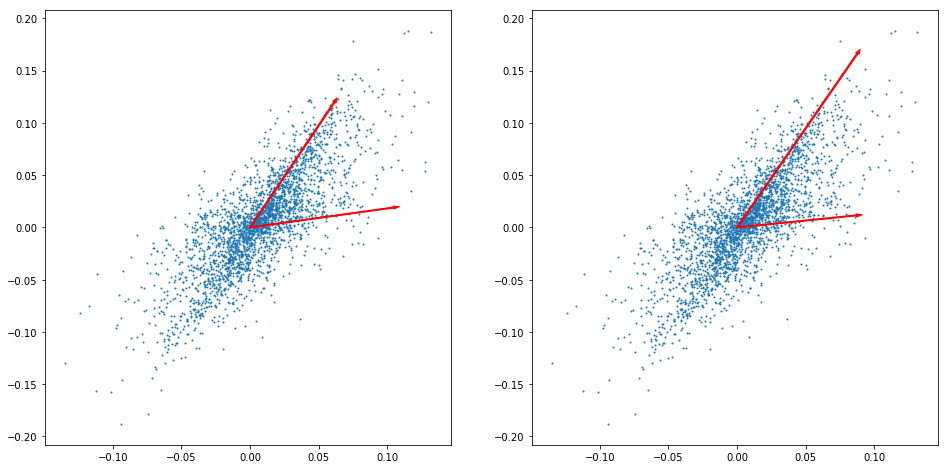

In [14]:
import random
inversesamplingrate = 50 # randomly take 1 out of every 50 samples
sampledXT = []
for col in np.transpose(X):
    if random.randint(1,inversesamplingrate) == 1:
        sampledXT.append(col)
sampledX = np.transpose(sampledXT)
sampledA, sampledS = bss(sampledX)
compareMixingMatrix(sampledX, gtruthA, sampledA)
# normalized sound tracks
sampledS = audionorm(sampledS)
# write recovered sound track into WAV files
wavfile.write('data/separatedsampledTrackA.wav', 22050, S[0])
wavfile.write('data/separatedsampledTrackB.wav', 22050, S[1])

Using the sampled data is much more efficient and noticably reduces compute time, but since we run until a convergence threshold is achieved, the results still sound the same and are on the same order of accuracy relative to our estimated matrix, and the quality of the sound files indicates minimal distance from the ground truth.  Even with only 1/50 of the original datapoints, we can still accurately estimate the mixing matrix in a small fraction of the original time.